# Expedia recommendation

From statistics about liked and disliked hotels, we're going to create a model to predict wether a particular user will like or dislike the hotel

Summary :

1. Data Collection
2. Feature engineering
3. Methodology
4. Testing on test data

## 1. Data Collection

A training set of .... rows and a test set of .... rows is given in a csv file

| Field | Data Type | Description |
| --- | --- | --- |
| srch_id | Date/time | Date and time of the search |
| date_time | Integer | ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ..) |
| site_id | Integer | The ID of the search |
| visitor_location_country_id | Integer | The ID of the country the customer is located |
| visitor_hist_starrating | Float | The mean star rating of hotels the customer has previously purchased; null signifies there is no purchase history on the customer |
| visitor_hist_adr_usd | Float | Themean price per night (in US$) of the hotels the customer has previously purchased; null signifies there is no purchase history on the customer |
| prop_country_id | Integer | The ID of the country the hotel is located in |
| prop_id | Integer | The ID of the hotel |
| prop_starrating | Integer |  The star rating of the hotel, from 1 to 5, in increments of 1. A 0 indicates the property has no
stars, the star rating is not known or cannot be publicized |
| prop_review_score | Float | The mean customer review score for the hotel on a scale out of 5, rounded to 0.5 increments.
A 0 means there have been no reviews, null that the information is not available |
| prop_brand_bool | Integer | +1 if the hotel is part of a major hotel chain; 0 if it is an independent hotel |
| prop_location_score1 | Float | A (first) score outlining the desirability of a hotel’s location |
| prop_location_score2 | Float | A (second) score outlining the desirability of the hotel’s location |
| prop_log_historical_price | Float | The logarithm of themean price of the hotel over the last trading period. A 0 will occur if the
hotel was not sold in that period |
| price_usd | Float | Displayed price of the hotel for the given search. Note that different countries have different
conventions regarding displaying taxes and fees and the value may be per night or for the
whole stay |
| promotion_flag | Integer | +1 if the hotel had a sale price promotion specifically displayed |
| srch_destination_id | Integer | ID of the destination where the hotel search was performed |
| srch_length_of_stay | Integer | Number of nights stay that was searched |
| srch_booking_window | Integer | Number of days in the future the hotel stay started from the search date |
| srch_adults_count | Integer | The number of adults specified in the hotel room |
| srch_children_count | Integer | The number of (extra occupancy) children specified in the hotel room |
| srch_room_count | Integer | Number of hotel rooms specified in the search |
| srch_saturday_night_bool | Boolean | +1 if the stay includes a Saturday night, starts fromThursday with a length of stay is less than or equal to 4 nights (i.e. weekend); otherwise 0 |
| srch_query_affinity_score | Float | The log of the probability a hotel will be clicked on in Internet searches (hence the values are negative) A null signifies there are no data (i.e. hotel did not register in any searches) |
| orig_destination_distance | Float | Physical distance between the hotel and the customer at the time of search. A null means the distance could not be calculated |
| random_bool | Boolean | +1 when the displayed sort was random, 0 when the normal sort order was displayed |
| comp1_rate | Integer | +1 if Expedia has a lower price than competitor 1 for the hotel; 0 if the same; -1 if Expedia’s
price is higher than competitor 1; null signifies there is no competitive data |
| comp1_inv | Integer | +1 if competitor 1 does not have availability in the hotel; 0 if both Expedia and competitor 1
have availability; null signifies there is no competitive data |
| comp1_rate_percent_diff | Float | The absolute percentage difference (if one exists) between Expedia and competitor 1’s price
(Expedia’s price the denominator); null signifies there is no competitive data |
| comp2_rate |  | |
| comp2_inv |  | |
| comp2_rate_percent_diff |  | |
| ... |  | |
| comp8_rate |  | |
| comp8_in |  | |
| comp8_rate_percent_diff |  | |
| --- | --- | --- |
| Training set only |
| position | Integer | Hotel position on Expedia’s search results page. This is only provided for the training data,
but not the test data |
| click_bool | Boolean | 1 if the user clicked on the property, 0 if not |
| booking_bool | Boolean | 1 if the user booked the property, 0 if not |
| gross_booking_usd | Float | Total value of the transaction. This can differ from the price_usd due to taxes, fees, conventions
on multiple day bookings and purchase of a room type other than the one shown in the
search |




## 2. Feature engineering

1. Prediction value
2. Ranking (price ranking, star rate ranking, review score ranking, location score ranking)
3. Competitor rate
4. Datetime
5. Rating and price difference
6. Clusters


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import lightgbm as lgb

## 1. Data collection

In [3]:
training_data = pd.read_csv('training_set_VU_DM.csv') 

## 2. Feature engineering

In [4]:
training_data['date_time'] = pd.to_datetime(training_data['date_time'])

training_data['Cin_hour'] = training_data["date_time"].apply(lambda x: x.hour)
training_data['Cin_day'] = training_data["date_time"].apply(lambda x: x.day)
training_data['Cin_month'] = training_data["date_time"].apply(lambda x: x.month)
training_data['Cin_quarter'] = training_data["date_time"].apply(lambda x: x.quarter)
training_data['Cin_day_of_week'] = training_data['date_time'].dt.dayofweek+1 #we don't want zeros

training_data.drop('date_time',axis=1,inplace=True)

In [5]:
training_data['priceRank'] = training_data.groupby('srch_id')['price_usd'].rank()
training_data['starRank'] = training_data.groupby('srch_id')['prop_starrating'].rank()
training_data['reviewRank'] = training_data.groupby('srch_id')['prop_review_score'].rank()
training_data['location1Rank'] = training_data.groupby('srch_id')['prop_location_score1'].rank()
training_data['location2Rank'] = training_data.groupby('srch_id')['prop_location_score2'].rank()
training_data['histpriceRank'] = training_data.groupby('srch_id')['prop_log_historical_price'].rank()

In [6]:
training_data['rating_diff']=abs(training_data['visitor_hist_starrating']-training_data['prop_starrating'])
training_data['rating_diff']=training_data['rating_diff'].fillna(training_data['rating_diff'].mean())

training_data['price_diff']=abs(training_data['visitor_hist_adr_usd']-training_data['price_usd'])
training_data['price_diff']=training_data['price_diff'].fillna(training_data['price_diff'].mean())

In [7]:
# creating new features
training_data['competitor_rate'] = (training_data.comp1_rate + training_data.comp2_rate + training_data.comp3_rate +
                                    training_data.comp4_rate + training_data.comp5_rate + training_data.comp6_rate +
                                    training_data.comp7_rate + training_data.comp8_rate)

training_data['competitor_inv'] = (training_data.comp1_inv + training_data.comp2_inv + training_data.comp3_inv +
                                    training_data.comp4_inv + training_data.comp5_inv + training_data.comp6_inv +
                                    training_data.comp7_inv + training_data.comp8_inv)

training_data['competitor_rpd'] = (  training_data.comp1_rate_percent_diff + training_data.comp2_rate_percent_diff
                                   + training_data.comp3_rate_percent_diff + training_data.comp4_rate_percent_diff
                                   + training_data.comp5_rate_percent_diff + training_data.comp6_rate_percent_diff
                                   + training_data.comp7_rate_percent_diff + training_data.comp8_rate_percent_diff) /8/100

training_data.drop('comp1_rate',axis=1,inplace=True)
training_data.drop('comp2_rate',axis=1,inplace=True)
training_data.drop('comp3_rate',axis=1,inplace=True)
training_data.drop('comp4_rate',axis=1,inplace=True)
training_data.drop('comp5_rate',axis=1,inplace=True)
training_data.drop('comp6_rate',axis=1,inplace=True)
training_data.drop('comp7_rate',axis=1,inplace=True)
training_data.drop('comp8_rate',axis=1,inplace=True)
training_data.drop('comp1_inv',axis=1,inplace=True)
training_data.drop('comp1_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp2_inv',axis=1,inplace=True)
training_data.drop('comp2_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp3_inv',axis=1,inplace=True)
training_data.drop('comp3_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp4_inv',axis=1,inplace=True)
training_data.drop('comp4_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp5_inv',axis=1,inplace=True)
training_data.drop('comp5_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp6_inv',axis=1,inplace=True)
training_data.drop('comp6_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp7_inv',axis=1,inplace=True)
training_data.drop('comp7_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp8_inv',axis=1,inplace=True)
training_data.drop('comp8_rate_percent_diff',axis=1,inplace=True)

In [8]:
training_data['assign_score'] = training_data.click_bool + 4*training_data.booking_bool
training_data = training_data.drop(['click_bool', 'booking_bool'],axis = 1)

In [9]:
training_data = training_data[training_data.price_usd < 1800]

In [10]:
training_data = training_data.fillna(0)

In [11]:
clustering_kmeans = MiniBatchKMeans(n_clusters=100)
training_data['hotel_cluster'] = clustering_kmeans.fit_predict(training_data)

C:\Users\loesv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


## 3. Methodology

### Preparing training and validation set

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(training_data, training_data.assign_score , test_size=0.30, random_state=42)

In [13]:
training_data = training_data.sort_values('srch_id')
training_data = training_data.reset_index(drop=True)
training_data_groups = training_data.srch_id.value_counts(sort=True,ascending=True).sort_index()
y_training = training_data.assign_score

train_search_ids = training_data.srch_id

training_data.drop(['gross_bookings_usd', 'position'],axis=1,inplace=True)

In [14]:
X_train = X_train.sort_values('srch_id')
X_train = X_train.reset_index(drop = True)
y_train = X_train.assign_score
train_search_ids = X_train.srch_id
train_groups = X_train.srch_id.value_counts(sort=True,ascending=True).sort_index()

X_train.drop(['gross_bookings_usd', 'position'],axis=1,inplace=True)

In [15]:
X_val = X_val.sort_values('srch_id')
X_val = X_val.reset_index(drop = True)
y_val = X_val.assign_score
val_groups = X_val.srch_id.value_counts(sort=True,ascending=True).sort_index()
val_search_ids = X_val.srch_id

X_val.drop(['gross_bookings_usd', 'position'],axis=1,inplace=True)

In [16]:
training_data.drop(['srch_id', 'assign_score'],axis=1,inplace=True)
X_train.drop(['srch_id', 'assign_score'],axis=1,inplace=True)
X_val.drop(['srch_id', 'assign_score'],axis=1,inplace=True)

### LGB Model

In [17]:
model2 = lgb.LGBMRanker(objective='lambdarank',n_estimators= 300, num_leaves=100,learning_rate= 0.1,score='ndcg',
                       subsample=0.8,subsample_freq=-1, boosting_type = 'goss')

model2.fit(X_train, y_train, group=train_groups, eval_set = [(X_val,y_val)], eval_group=[val_groups])

[LightGBM] [Warning] Unknown parameter: score
[1]	valid_0's ndcg@1: 0.785423	valid_0's ndcg@2: 0.82508	valid_0's ndcg@3: 0.846877	valid_0's ndcg@4: 0.860276	valid_0's ndcg@5: 0.869015
[2]	valid_0's ndcg@1: 0.792094	valid_0's ndcg@2: 0.831456	valid_0's ndcg@3: 0.85306	valid_0's ndcg@4: 0.865926	valid_0's ndcg@5: 0.874365
[3]	valid_0's ndcg@1: 0.794244	valid_0's ndcg@2: 0.834106	valid_0's ndcg@3: 0.855433	valid_0's ndcg@4: 0.868184	valid_0's ndcg@5: 0.876472
[4]	valid_0's ndcg@1: 0.796089	valid_0's ndcg@2: 0.836164	valid_0's ndcg@3: 0.857279	valid_0's ndcg@4: 0.869951	valid_0's ndcg@5: 0.878015
[5]	valid_0's ndcg@1: 0.797081	valid_0's ndcg@2: 0.837226	valid_0's ndcg@3: 0.858089	valid_0's ndcg@4: 0.870647	valid_0's ndcg@5: 0.878557
[6]	valid_0's ndcg@1: 0.797792	valid_0's ndcg@2: 0.838344	valid_0's ndcg@3: 0.859003	valid_0's ndcg@4: 0.871475	valid_0's ndcg@5: 0.879248
[7]	valid_0's ndcg@1: 0.798497	valid_0's ndcg@2: 0.838832	valid_0's ndcg@3: 0.859407	valid_0's ndcg@4: 0.871979	valid_0's 

[60]	valid_0's ndcg@1: 0.804385	valid_0's ndcg@2: 0.84432	valid_0's ndcg@3: 0.864898	valid_0's ndcg@4: 0.876791	valid_0's ndcg@5: 0.884326
[61]	valid_0's ndcg@1: 0.804405	valid_0's ndcg@2: 0.844397	valid_0's ndcg@3: 0.86496	valid_0's ndcg@4: 0.876887	valid_0's ndcg@5: 0.884373
[62]	valid_0's ndcg@1: 0.804426	valid_0's ndcg@2: 0.844449	valid_0's ndcg@3: 0.865023	valid_0's ndcg@4: 0.876884	valid_0's ndcg@5: 0.88439
[63]	valid_0's ndcg@1: 0.804461	valid_0's ndcg@2: 0.844443	valid_0's ndcg@3: 0.865043	valid_0's ndcg@4: 0.876929	valid_0's ndcg@5: 0.884413
[64]	valid_0's ndcg@1: 0.804547	valid_0's ndcg@2: 0.844439	valid_0's ndcg@3: 0.865021	valid_0's ndcg@4: 0.876956	valid_0's ndcg@5: 0.884444
[65]	valid_0's ndcg@1: 0.804694	valid_0's ndcg@2: 0.844557	valid_0's ndcg@3: 0.865146	valid_0's ndcg@4: 0.876994	valid_0's ndcg@5: 0.884552
[66]	valid_0's ndcg@1: 0.804801	valid_0's ndcg@2: 0.84465	valid_0's ndcg@3: 0.865236	valid_0's ndcg@4: 0.877064	valid_0's ndcg@5: 0.884628
[67]	valid_0's ndcg@1: 0

[119]	valid_0's ndcg@1: 0.805657	valid_0's ndcg@2: 0.845787	valid_0's ndcg@3: 0.866142	valid_0's ndcg@4: 0.877939	valid_0's ndcg@5: 0.885396
[120]	valid_0's ndcg@1: 0.805641	valid_0's ndcg@2: 0.845823	valid_0's ndcg@3: 0.866167	valid_0's ndcg@4: 0.877967	valid_0's ndcg@5: 0.885392
[121]	valid_0's ndcg@1: 0.805611	valid_0's ndcg@2: 0.845851	valid_0's ndcg@3: 0.866176	valid_0's ndcg@4: 0.877975	valid_0's ndcg@5: 0.885396
[122]	valid_0's ndcg@1: 0.80557	valid_0's ndcg@2: 0.845833	valid_0's ndcg@3: 0.866171	valid_0's ndcg@4: 0.877967	valid_0's ndcg@5: 0.885413
[123]	valid_0's ndcg@1: 0.805489	valid_0's ndcg@2: 0.845739	valid_0's ndcg@3: 0.86611	valid_0's ndcg@4: 0.877897	valid_0's ndcg@5: 0.885381
[124]	valid_0's ndcg@1: 0.805596	valid_0's ndcg@2: 0.845773	valid_0's ndcg@3: 0.866159	valid_0's ndcg@4: 0.877945	valid_0's ndcg@5: 0.88541
[125]	valid_0's ndcg@1: 0.805585	valid_0's ndcg@2: 0.845889	valid_0's ndcg@3: 0.866174	valid_0's ndcg@4: 0.877952	valid_0's ndcg@5: 0.885445
[126]	valid_0's 

[179]	valid_0's ndcg@1: 0.805846	valid_0's ndcg@2: 0.84619	valid_0's ndcg@3: 0.866451	valid_0's ndcg@4: 0.87811	valid_0's ndcg@5: 0.885585
[180]	valid_0's ndcg@1: 0.805871	valid_0's ndcg@2: 0.8462	valid_0's ndcg@3: 0.866433	valid_0's ndcg@4: 0.878101	valid_0's ndcg@5: 0.885585
[181]	valid_0's ndcg@1: 0.805881	valid_0's ndcg@2: 0.846216	valid_0's ndcg@3: 0.866437	valid_0's ndcg@4: 0.878106	valid_0's ndcg@5: 0.885608
[182]	valid_0's ndcg@1: 0.805926	valid_0's ndcg@2: 0.846209	valid_0's ndcg@3: 0.866447	valid_0's ndcg@4: 0.878126	valid_0's ndcg@5: 0.885623
[183]	valid_0's ndcg@1: 0.805906	valid_0's ndcg@2: 0.846198	valid_0's ndcg@3: 0.866404	valid_0's ndcg@4: 0.878079	valid_0's ndcg@5: 0.885603
[184]	valid_0's ndcg@1: 0.805921	valid_0's ndcg@2: 0.846227	valid_0's ndcg@3: 0.866432	valid_0's ndcg@4: 0.87809	valid_0's ndcg@5: 0.885624
[185]	valid_0's ndcg@1: 0.805947	valid_0's ndcg@2: 0.846257	valid_0's ndcg@3: 0.866436	valid_0's ndcg@4: 0.878127	valid_0's ndcg@5: 0.885635
[186]	valid_0's nd

[238]	valid_0's ndcg@1: 0.805786	valid_0's ndcg@2: 0.845956	valid_0's ndcg@3: 0.866182	valid_0's ndcg@4: 0.87806	valid_0's ndcg@5: 0.885505
[239]	valid_0's ndcg@1: 0.805771	valid_0's ndcg@2: 0.845986	valid_0's ndcg@3: 0.866178	valid_0's ndcg@4: 0.878059	valid_0's ndcg@5: 0.885483
[240]	valid_0's ndcg@1: 0.805766	valid_0's ndcg@2: 0.845977	valid_0's ndcg@3: 0.866175	valid_0's ndcg@4: 0.878054	valid_0's ndcg@5: 0.885482
[241]	valid_0's ndcg@1: 0.805761	valid_0's ndcg@2: 0.845984	valid_0's ndcg@3: 0.866149	valid_0's ndcg@4: 0.878048	valid_0's ndcg@5: 0.885471
[242]	valid_0's ndcg@1: 0.805821	valid_0's ndcg@2: 0.845966	valid_0's ndcg@3: 0.86618	valid_0's ndcg@4: 0.87807	valid_0's ndcg@5: 0.885482
[243]	valid_0's ndcg@1: 0.805827	valid_0's ndcg@2: 0.84599	valid_0's ndcg@3: 0.866199	valid_0's ndcg@4: 0.878081	valid_0's ndcg@5: 0.885494
[244]	valid_0's ndcg@1: 0.805857	valid_0's ndcg@2: 0.846012	valid_0's ndcg@3: 0.866197	valid_0's ndcg@4: 0.878068	valid_0's ndcg@5: 0.885487
[245]	valid_0's n

[298]	valid_0's ndcg@1: 0.805856	valid_0's ndcg@2: 0.846052	valid_0's ndcg@3: 0.866213	valid_0's ndcg@4: 0.878071	valid_0's ndcg@5: 0.885502
[299]	valid_0's ndcg@1: 0.805897	valid_0's ndcg@2: 0.846092	valid_0's ndcg@3: 0.866235	valid_0's ndcg@4: 0.878092	valid_0's ndcg@5: 0.885515
[300]	valid_0's ndcg@1: 0.805942	valid_0's ndcg@2: 0.846067	valid_0's ndcg@3: 0.866209	valid_0's ndcg@4: 0.878089	valid_0's ndcg@5: 0.885522


LGBMRanker(boosting_type='goss', n_estimators=300, num_leaves=100,
           objective='lambdarank', score='ndcg', subsample=0.8,
           subsample_freq=-1)

In [18]:
evaluation_lgb = model2.evals_result_

In [19]:
print(evaluation_lgb['valid_0']['ndcg@5'][-1])

0.8855220034122449


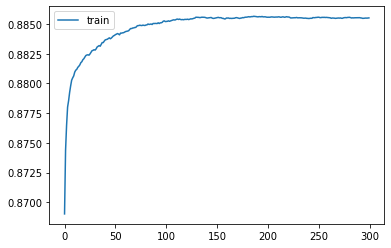

In [20]:
from matplotlib import pyplot
# plot learning curves
pyplot.plot(evaluation_lgb['valid_0']['ndcg@5'], label='train')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### XGBoost model

In [23]:
import xgboost as xgb

model3 = xgb.sklearn.XGBRanker(objective = 'rank:pairwise', learning_rate= 0.1,gamma= 1.0, min_child_weight= 0.1,
                                n_estimators= 100,subsample=0.7,max_depth=8,booster='gbtree', n_jobs = 4)
#gbtree or dart
model3.fit(X_train, y_train, train_groups, eval_set=[(X_val, y_val)], eval_group=[val_groups],eval_metric = 'ndcg')

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
          importance_type='gain', interaction_constraints='', learning_rate=0.1,
          max_delta_step=0, max_depth=8, min_child_weight=0.1, missing=nan,
          monotone_constraints='()', n_estimators=100, n_jobs=4,
          num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
          scale_pos_weight=None, subsample=0.7, tree_method='exact',
          validate_parameters=1, verbosity=None)

In [24]:
evaluation_xgb = model3.evals_result_

In [25]:
print(evaluation_xgb['validation_0']['ndcg'][-1])

0.898346


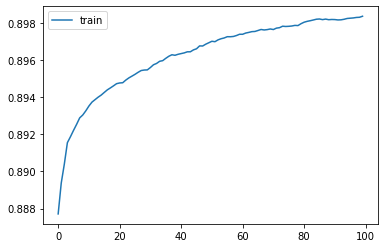

In [26]:
from matplotlib import pyplot
# plot learning curves
pyplot.plot(evaluation_xgb['validation_0']['ndcg'], label='train')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## 4. Testing on test data

### Preparing the test data

In [27]:
test_data = pd.read_csv('test_set_VU_DM.csv') 

In [28]:
test_data['date_time'] = pd.to_datetime(test_data['date_time'])

test_data['Cin_hour'] = test_data["date_time"].apply(lambda x: x.hour)
test_data['Cin_day'] = test_data["date_time"].apply(lambda x: x.day)
test_data['Cin_month'] = test_data["date_time"].apply(lambda x: x.month)
test_data['Cin_quarter'] = test_data["date_time"].apply(lambda x: x.quarter)
test_data['Cin_day_of_week'] = test_data['date_time'].dt.dayofweek+1 #we don't want zeros

test_data.drop('date_time',axis=1,inplace=True)

In [29]:
test_data['priceRank'] = test_data.groupby('srch_id')['price_usd'].rank()
test_data['starRank'] = test_data.groupby('srch_id')['prop_starrating'].rank()
test_data['reviewRank'] = test_data.groupby('srch_id')['prop_review_score'].rank()
test_data['location1Rank'] = test_data.groupby('srch_id')['prop_location_score1'].rank()
test_data['location2Rank'] = test_data.groupby('srch_id')['prop_location_score2'].rank()
test_data['histpriceRank'] = test_data.groupby('srch_id')['prop_log_historical_price'].rank()

In [30]:
test_data['rating_diff']=abs(test_data['visitor_hist_starrating']-test_data['prop_starrating'])
test_data['rating_diff']=test_data['rating_diff'].fillna(test_data['rating_diff'].mean())

test_data['price_diff']=abs(test_data['visitor_hist_adr_usd']-test_data['price_usd'])
test_data['price_diff']=test_data['price_diff'].fillna(test_data['price_diff'].mean())

In [31]:
test_data['competitor_rate'] = (test_data.comp1_rate + test_data.comp2_rate + test_data.comp3_rate +
                                test_data.comp4_rate + test_data.comp5_rate + test_data.comp6_rate +
                                test_data.comp7_rate + test_data.comp8_rate)

test_data['competitor_inv'] = (test_data.comp1_inv + test_data.comp2_inv + test_data.comp3_inv +
                               test_data.comp4_inv + test_data.comp5_inv + test_data.comp6_inv +
                               test_data.comp7_inv + test_data.comp8_inv)

test_data['competitor_rpd'] = (  test_data.comp1_rate_percent_diff + test_data.comp2_rate_percent_diff
                               + test_data.comp3_rate_percent_diff + test_data.comp4_rate_percent_diff
                               + test_data.comp5_rate_percent_diff + test_data.comp6_rate_percent_diff
                               + test_data.comp7_rate_percent_diff + test_data.comp8_rate_percent_diff)/8/100

test_data.drop('comp1_rate',axis=1,inplace=True)
test_data.drop('comp2_rate',axis=1,inplace=True)
test_data.drop('comp3_rate',axis=1,inplace=True)
test_data.drop('comp4_rate',axis=1,inplace=True)
test_data.drop('comp5_rate',axis=1,inplace=True)
test_data.drop('comp6_rate',axis=1,inplace=True)
test_data.drop('comp7_rate',axis=1,inplace=True)
test_data.drop('comp8_rate',axis=1,inplace=True)
test_data.drop('comp1_inv',axis=1,inplace=True)
test_data.drop('comp1_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp2_inv',axis=1,inplace=True)
test_data.drop('comp2_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp3_inv',axis=1,inplace=True)
test_data.drop('comp3_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp4_inv',axis=1,inplace=True)
test_data.drop('comp4_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp5_inv',axis=1,inplace=True)
test_data.drop('comp5_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp6_inv',axis=1,inplace=True)
test_data.drop('comp6_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp7_inv',axis=1,inplace=True)
test_data.drop('comp7_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp8_inv',axis=1,inplace=True)
test_data.drop('comp8_rate_percent_diff',axis=1,inplace=True)

In [32]:
test_data = test_data[test_data.price_usd < 1800]

In [33]:
test_data = test_data.fillna(0)

In [34]:
clustering_kmeans = MiniBatchKMeans(n_clusters=100)
test_data['hotel_cluster'] = clustering_kmeans.fit_predict(test_data)

C:\Users\loesv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [35]:
test_data = test_data.sort_values('srch_id')
test_data = test_data.reset_index(drop =True)
test_data_search_ids = test_data.srch_id

test_data_groups = test_data.srch_id.value_counts(sort=True,ascending=True).sort_index()

srch_id = test_data.srch_id
prop_id = test_data.prop_id
test_data.drop(['srch_id'],axis=1,inplace=True)

In [36]:
def create_result(rankings,srch_id,prop_id):
    predictions = pd.DataFrame(rankings,columns=['probs'])
    predictions = predictions.join(srch_id)
    predictions = predictions.join(prop_id)
    final_table = predictions.sort_values(by=['srch_id', 'probs'], ascending=[True, False])
    final_table.reset_index(drop = True, inplace = True)
    final_table = final_table.drop('probs',axis =1)
    
    return(final_table)

### Method 1 - LightGBM

In [37]:
rankings_lgb = model2.predict(test_data)

In [38]:
final_table_lgb2 = create_result(rankings_lgb,srch_id,prop_id)
final_table_lgb2.to_csv('rankings_lgb_cluster_booking4.csv',index = False)

### Method 2 - XGBoost

In [39]:
rankings_xgb = model3.predict(test_data)

In [40]:
final_table_xgb = create_result(rankings_xgb,srch_id,prop_id)
final_table_xgb.to_csv('rankings_xgb_cluster_300iterations.csv',index = False)

Compare LGB with XGB

In [41]:
table = pd.DataFrame()
table['srch_id'] = srch_id
table['prob_id_lgb'] = final_table_lgb2['prop_id']
table['prob_id_xgb'] = final_table_xgb['prop_id']
print(table)

         srch_id  prob_id_lgb  prob_id_xgb
0              1        99484        99484
1              1        54937        54937
2              1        61934        61934
3              1        24194        24194
4              1        28181        28181
...          ...          ...          ...
4953274   332787        32019        29018
4953275   332787        94437        32019
4953276   332787        29018        99509
4953277   332787        99509        94437
4953278   332787        35240        35240

[4953279 rows x 3 columns]
